# Set up imports

In [1]:
# setting up our imports
import re, string, unicodedata
import numpy as np
import pandas as pd
from pprint import pprint
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import LdaModel, LdaMulticore
import gensim.downloader as api
from gensim.models import LsiModel
from gensim.models import ldaseqmodel
from gensim.corpora import Dictionary, bleicorpus
from gensim.matutils import hellinger

nltk.download('wordnet')
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
#from bs4 import BeautifulSoup
#from nltk import word_tokenize, sent_tokenize

# Plotting tools 
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
# %matplotlib inline

# Enable logging for gensim - optional
#import logging
#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
#logging.root.setLevel(level=logging.INFO)
#import warnings
#warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kornelius\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\Kornelius\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Kornelius\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# load dataset

In [10]:
# Load dataset
# Load dataset
df = pd.read_excel('C:/Users/Kornelius/Desktop/Data 2/ecbpr/Warin_Sanger_ECB.xlsx') 
# Drop the columns not needed

C:\Users\Kornelius\Anaconda3\lib\site-packages\defusedxml\ElementTree.py:68: DeprecationWarning: The html argument of XMLParser() is deprecated
  _XMLParser.__init__(self, html, target, encoding)
C:\Users\Kornelius\Anaconda3\lib\site-packages\defusedxml\ElementTree.py:68: DeprecationWarning: The html argument of XMLParser() is deprecated
  _XMLParser.__init__(self, html, target, encoding)
C:\Users\Kornelius\Anaconda3\lib\site-packages\defusedxml\ElementTree.py:68: DeprecationWarning: The html argument of XMLParser() is deprecated
  _XMLParser.__init__(self, html, target, encoding)
C:\Users\Kornelius\Anaconda3\lib\site-packages\defusedxml\ElementTree.py:68: DeprecationWarning: The html argument of XMLParser() is deprecated
  _XMLParser.__init__(self, html, target, encoding)
C:\Users\Kornelius\Anaconda3\lib\site-packages\defusedxml\ElementTree.py:68: DeprecationWarning: The html argument of XMLParser() is deprecated
  _XMLParser.__init__(self, html, target, encoding)
C:\Users\Kornelius\A

In [11]:
df['word_count'] = df['Press'].apply(lambda x: len(str(x).split(" ")))
df[['Press','word_count']].head()
df.word_count.describe()

count     205.000000
mean     1438.653659
std       364.094649
min       261.000000
25%      1196.000000
50%      1370.000000
75%      1694.000000
max      3101.000000
Name: word_count, dtype: float64

In [12]:
# sort by year
df = df.sort_values(by=['Date'])

In [13]:
df = df[ df['Date'] == 2016 ]

In [14]:
# sort by year
data = df['Press']

In [15]:
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string
stop = set(stopwords.words('english'))
exclude = set(string.punctuation) 
lemma = WordNetLemmatizer()
def clean(data):
    stop_free = " ".join([i for i in data.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

data = [clean(data).split()for data in data]  

In [16]:
# remove characters and numbers
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

In [17]:
from nltk.probability import FreqDist
result = str(data_words).strip('[]')
freq = pd.Series(''.join(result).split()).value_counts()
freq
# turn series into df
df = freq.to_frame().reset_index()
df.columns = ['words','counts']
df

,words,counts
0,"'monetary',",123
1,"'area',",113
2,"'policy',",113
3,"'euro',",105
4,"'growth',",90
5,"'rate',",89
6,"'inflation',",85
7,"'economic',",84
8,"'annual',",65
9,"'loan',",61


(array([  0.,  20.,  40.,  60.,  80., 100., 120., 140.]),
 <a list of 8 Text yticklabel objects>)

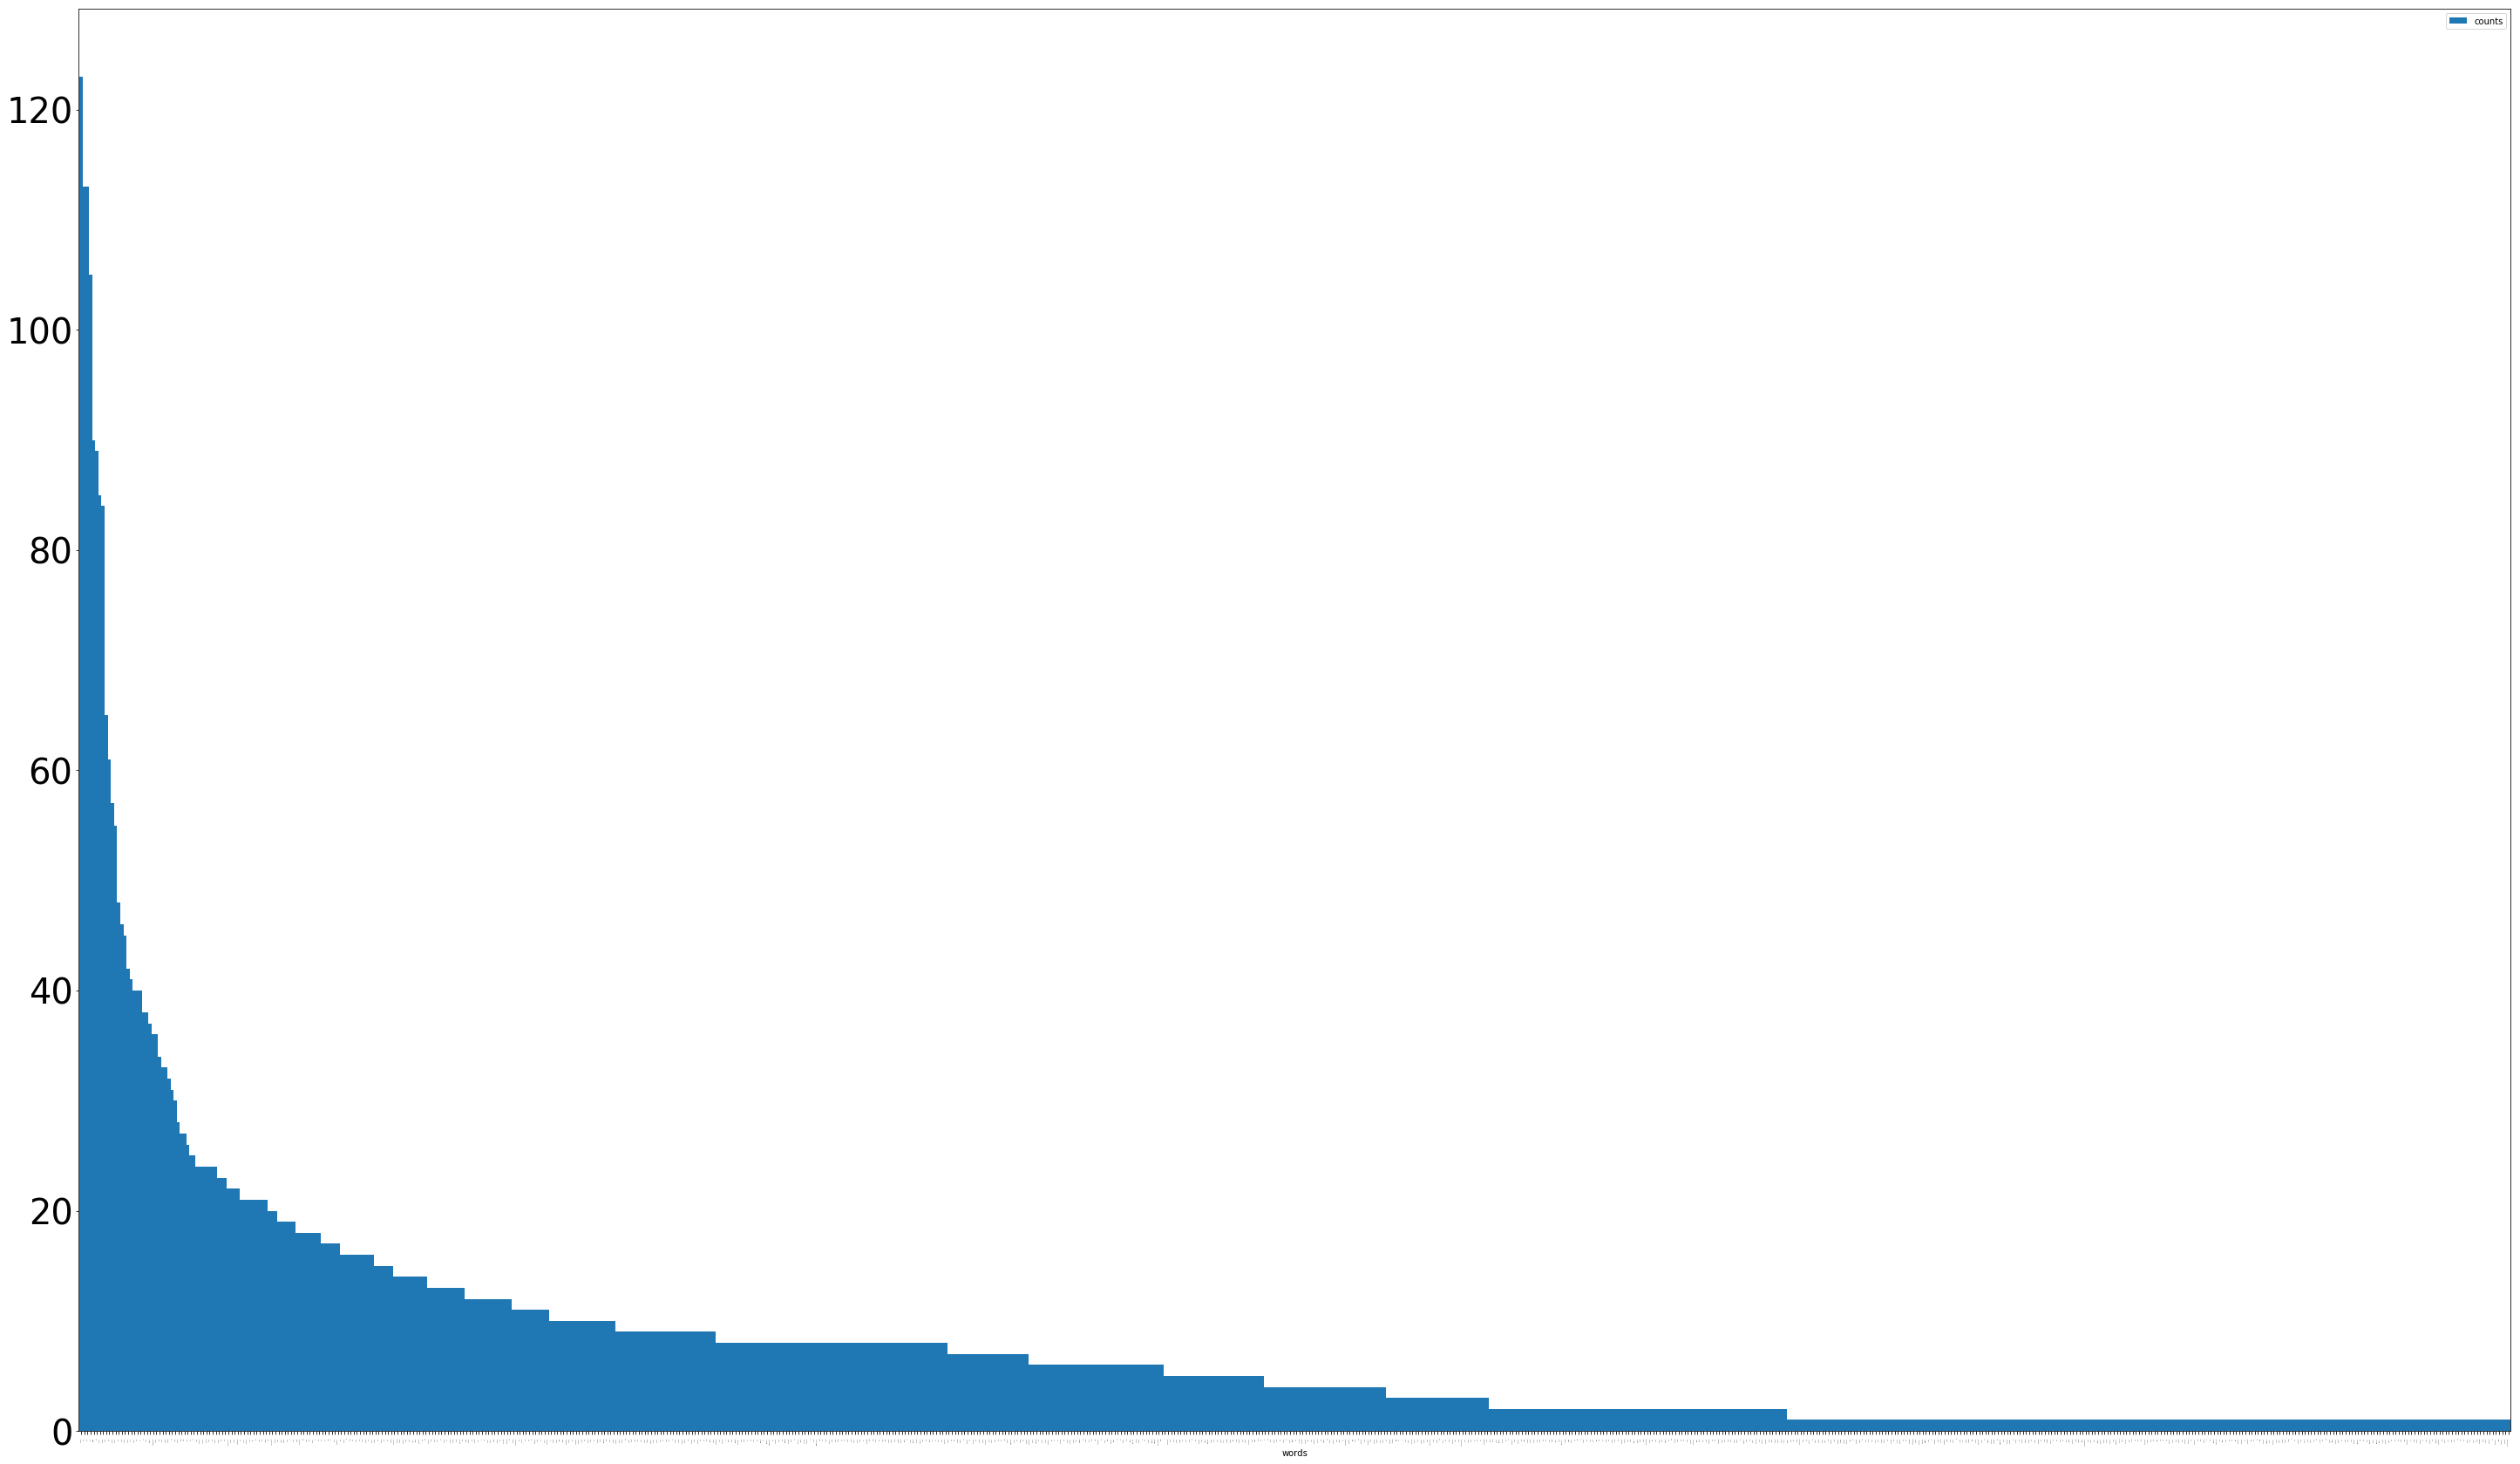

In [150]:
# draw graph
ax = df.plot.bar(x='words', y='counts', rot=0, figsize=(50,30), width=1)


plt.xticks(size = 1)
plt.xticks(rotation=90)
plt.yticks(size = 40)

In [151]:
data = data_words
# Create Dictionary
id2word = corpora.Dictionary(data)
print((id2word))

Dictionary(774 unique tokens: ['accommodation', 'accommodative', 'according', 'across', 'act']...)


In [158]:
# less than 10 documents,
id2word = corpora.Dictionary(data)
#id2word.filter_n_most_frequent(10)
#id2word.filter_extremes(no_above = 0.90)
id2word.filter_extremes(no_above = 0.98)
#id2word.filter_extremes(no_above = 0.99)
#id2word.filter_extremes(no_below = 4)
#id2word.filter_extremes(no_below = 10)
#id2word.filter_extremes(no_below = 50)
print((id2word))

Dictionary(132 unique tokens: ['accommodation', 'according', 'act', 'addition', 'additional']...)


In [159]:
texts = data
# Term Document Frequency and creating corpus
corpus = [id2word.doc2bow(text) for text in texts]

In [160]:
import gensim.downloader as api
from gensim.models import TfidfModel
from gensim.corpora import Dictionary

vocab_tf={}
for i in corpus:
    for item,count in dict(i).items():
        if item in vocab_tf:
            vocab_tf[item]+=count
        else:
            vocab_tf[item] = count

In [161]:
dictList= []
for key, value in sorted(vocab_tf.items()):
    dictList.append([key, value])
dictList

[[0, 6],
 [1, 7],
 [2, 6],
 [3, 8],
 [4, 7],
 [5, 7],
 [6, 5],
 [7, 14],
 [8, 16],
 [9, 5],
 [10, 8],
 [11, 7],
 [12, 9],
 [13, 14],
 [14, 5],
 [15, 7],
 [16, 6],
 [17, 11],
 [18, 6],
 [19, 8],
 [20, 5],
 [21, 9],
 [22, 5],
 [23, 6],
 [24, 7],
 [25, 12],
 [26, 5],
 [27, 13],
 [28, 7],
 [29, 12],
 [30, 6],
 [31, 5],
 [32, 6],
 [33, 7],
 [34, 10],
 [35, 8],
 [36, 11],
 [37, 11],
 [38, 5],
 [39, 7],
 [40, 7],
 [41, 6],
 [42, 7],
 [43, 5],
 [44, 7],
 [45, 8],
 [46, 6],
 [47, 21],
 [48, 22],
 [49, 6],
 [50, 9],
 [51, 8],
 [52, 6],
 [53, 6],
 [54, 8],
 [55, 17],
 [56, 8],
 [57, 7],
 [58, 13],
 [59, 6],
 [60, 6],
 [61, 8],
 [62, 15],
 [63, 6],
 [64, 5],
 [65, 9],
 [66, 9],
 [67, 13],
 [68, 7],
 [69, 24],
 [70, 5],
 [71, 10],
 [72, 8],
 [73, 6],
 [74, 6],
 [75, 9],
 [76, 8],
 [77, 6],
 [78, 8],
 [79, 6],
 [80, 6],
 [81, 13],
 [82, 7],
 [83, 7],
 [84, 5],
 [85, 25],
 [86, 6],
 [87, 5],
 [88, 12],
 [89, 7],
 [90, 5],
 [91, 6],
 [92, 8],
 [93, 7],
 [94, 16],
 [95, 6],
 [96, 7],
 [97, 12],
 [98, 1

In [162]:
df = pd.DataFrame(dictList) 
df = df.sort_values(ascending = False, by = 1)
df.columns = ['words','counts']
df
Total = df['counts'].sum()
Total


1104

(0.0, 120)

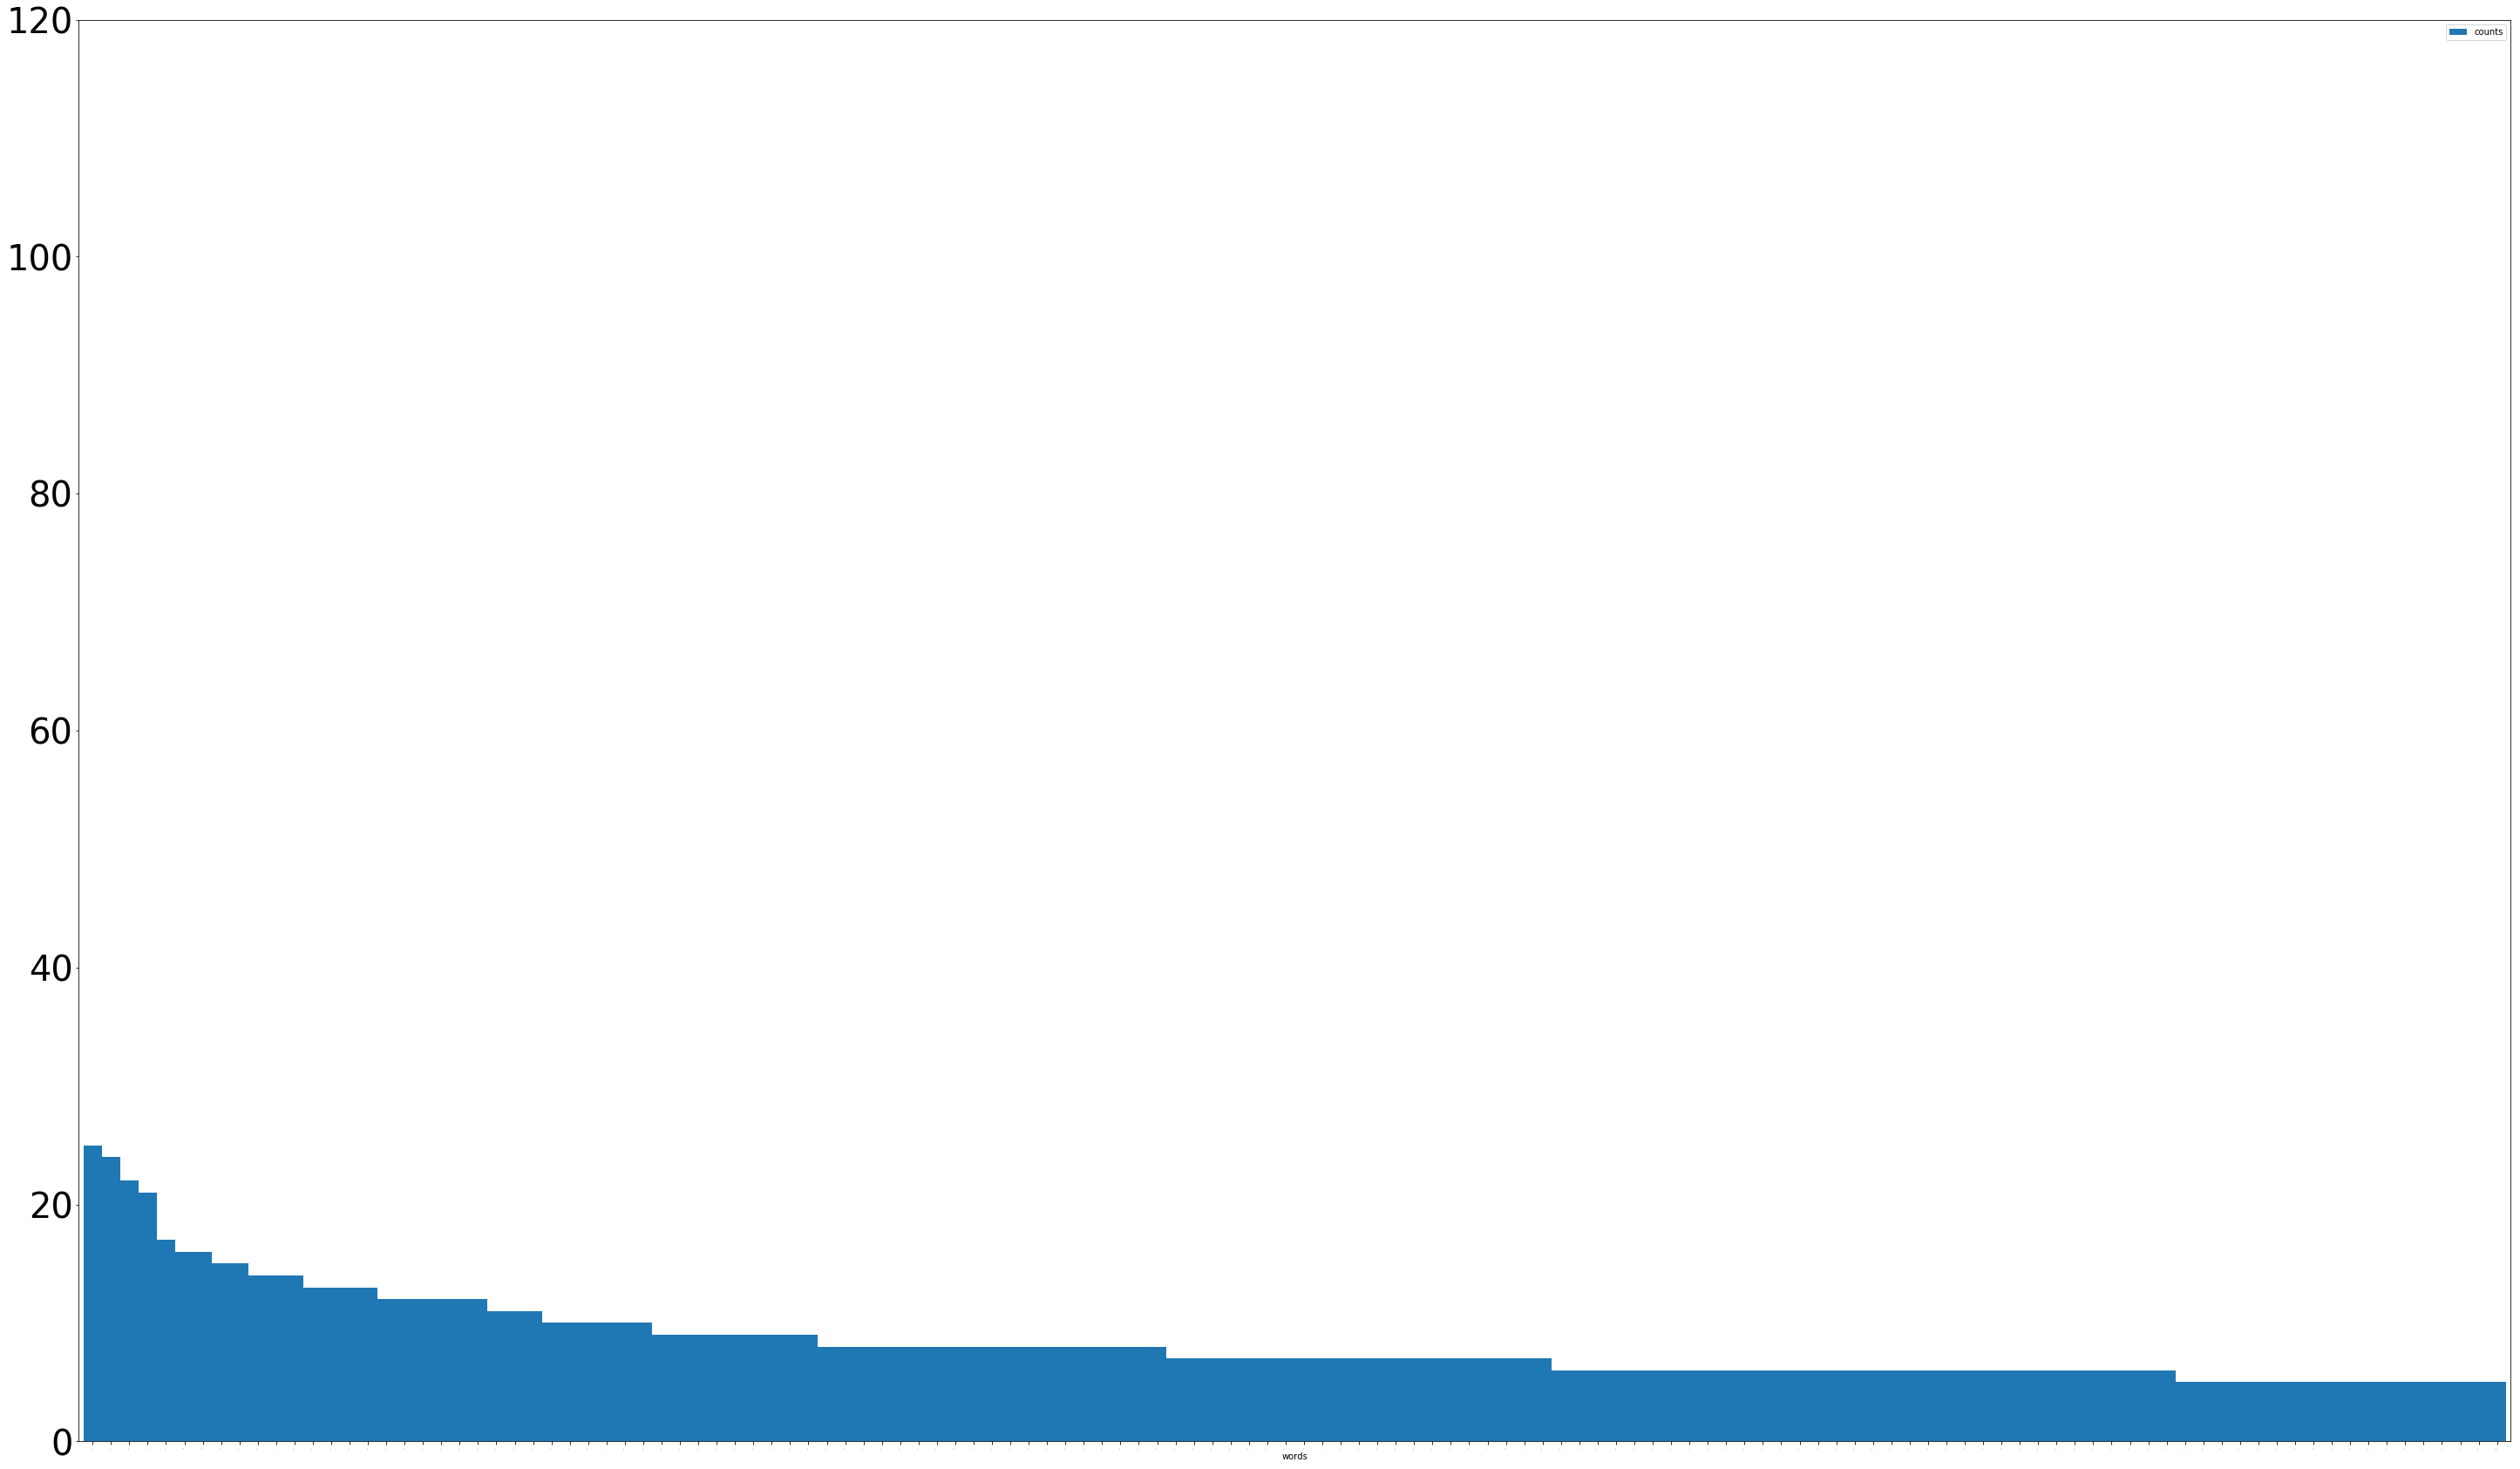

In [163]:
ax = df.plot.bar(x='words', y='counts', rot=0, figsize=(50,30), width=1)


plt.xticks(size = 1)
plt.xticks(rotation=90)
plt.yticks(size = 40)
plt.ylim(top = 120)

In [164]:
#plt.bar(*zip(*vocab_tf.items()))
#plt.show()